Alex - Research - 11. 3. 21

## de Prado: Trend Following Strategy with sample weights, purged CV, feature importance


This note book is another illustration of triple barrier labeling and meta labeling

In [13]:
# Import all the stuff we need

import mlfinlab as ml
import numpy as np
import pandas as pd
#import pyfolio as pf
import timeit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from mlfinlab.feature_importance.importance import mean_decrease_impurity
from mlfinlab.feature_importance.importance import mean_decrease_accuracy

from mlfinlab.feature_importance.importance import single_feature_importance, plot_feature_importance
from mlfinlab.ensemble import SequentiallyBootstrappedBaggingClassifier
from mlfinlab.sample_weights import get_weights_by_return, get_weights_by_time_decay
import matplotlib.pyplot as plt
%matplotlib inline


#### Read in the data

Again we will use dollar bars due to better statistical properties

In [9]:
data = pd.read_csv('C:/Users/axarz/Desktop/Thesis/sample_dollar_bars.csv')
data.index = pd.to_datetime(data["date_time"])
data = data.drop("date_time", axis=1)
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


#### Fit Primary model: moving average cross-over strategy

In [17]:
fast_window = 20
slow_window = 50

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
data.head()

# Compute sides
data['side'] = np.nan

long_signals = data['fast_mavg'] >= data['slow_mavg'] 
short_signals = data['fast_mavg'] < data['slow_mavg'] 
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115,NaN,NaN,NaN
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422,NaN,NaN,NaN
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727,NaN,NaN,NaN
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987,NaN,NaN,NaN
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499,NaN,NaN,NaN


In [18]:
# save raw data for feature augmentation later
raw_data = data.copy()

# drop NAN's

data.dropna(axis=0, how="any", inplace=True)
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2011-08-01 19:47:28.084,1283.25,1285.00,1283.00,1283.50,54519,70006655.50,9732,1276.5000,1284.360,-1.0
2011-08-01 19:53:37.773,1283.50,1285.00,1281.50,1282.25,54566,70031205.50,7999,1276.6375,1283.875,-1.0
2011-08-01 19:58:00.210,1282.25,1282.75,1279.75,1282.50,54634,70005370.75,7054,1276.9625,1283.425,-1.0
2011-08-01 20:00:00.200,1282.50,1283.25,1282.50,1282.50,54669,70128748.00,3663,1277.4625,1283.075,-1.0
2011-08-01 20:10:06.606,1282.50,1282.75,1281.00,1282.50,54610,70001487.50,7255,1277.9625,1282.570,-1.0


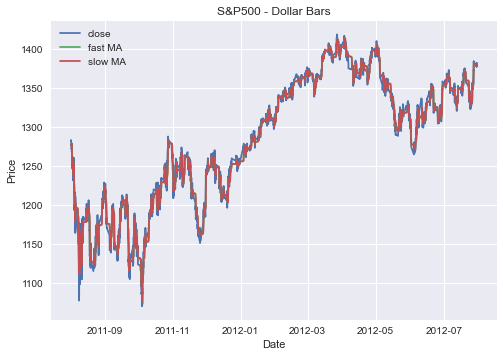

In [20]:
# let's take a look
plt.style.use('seaborn')
plt.title('S&P500 - Dollar Bars')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data.close, label= "close")
plt.plot(data.fast_mavg, color= "g", label= "fast MA")
plt.plot(data.fast_mavg, color= "r", label= "slow MA")
plt.legend()
plt.show()

#### Filter events: CUSUM

As before we filter the bars to only get those with a significant increase or decrease in volatility. 

In [21]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# i.e. we use cusum filter to get the events where there is a significant change in volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2011-08-02':'2012-07-30'].mean() * 0.1)

# vertical barriers
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data["close"], num_days=1)

In [22]:
# use triple barrier method to get labels and meta labels
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events, #so we enter on the CUSUM events, i.e. events with signif. changes in vola
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])


labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.head(5)

2021-03-11 17:40:16.574802 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


,ret,trgt,bin,side
2011-08-02 19:59:45.536,-0.002990,0.000598,0,-1.0
2011-08-02 20:03:20.466,-0.003986,0.000904,0,-1.0
2011-08-02 20:30:55.268,-0.004784,0.001099,0,-1.0
2011-08-03 01:53:52.265,-0.006378,0.001250,0,-1.0
2011-08-03 07:30:33.556,-0.003986,0.001932,0,-1.0


#### Results of the primary model

Confusion Matrix
[[   0 3098]
 [   0 3237]]

Accuracy
0.5109707971586425


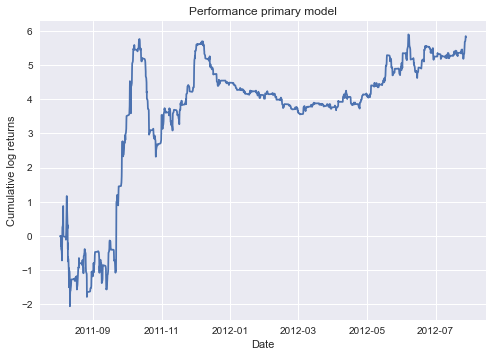

In [23]:
### Results of primary model 
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']


print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

# compute log returns
log_r = np.log(1+labels.ret)
cusum_log_r = log_r.cumsum()
plt.plot(cusum_log_r)
plt.title("Performance primary model")
plt.xlabel('Date')
plt.ylabel('Cumulative log returns')
plt.show()

### Fit the meta model

Now we will use the meta labels from labels df to fit meta model and see if we can improve the primary model.

We will use same features as in mean reversion example:
- volatility
- serial correlation
- returns at the different lags from the serial correlation
- the sides from the SMavg strategy

In [25]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115,NaN,NaN,NaN
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422,NaN,NaN,NaN
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727,NaN,NaN,NaN
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987,NaN,NaN,NaN
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499,NaN,NaN,NaN


In [26]:
# augment raw data with features

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)


# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

# Remove look ahead bias !!!
raw_data = raw_data.shift(1)

# Let's check it out

raw_data.head()




,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side,...,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5
date_time,,,,,,,,,,,,,,,,,,,,,
2011-07-31 23:31:58.810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 02:55:17.443,1306.00,1308.75,1301.75,1305.75,53658.0,70035704.75,14115.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 07:25:56.319,1305.75,1309.50,1304.00,1306.50,53552.0,70006277.00,15422.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01 08:33:10.903,1306.75,1309.75,1304.75,1305.00,53543.0,70000901.00,14727.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000574,NaN,NaN,NaN,NaN
2011-08-01 10:51:41.842,1305.00,1305.00,1299.00,1300.00,53830.0,70094217.75,14987.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.001149,0.000574,NaN,NaN,NaN


Now get the bars with significant increase or decrease in volatility which we filtered before

In [27]:
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']


In [31]:
y.value_counts()

1    3237
0    3098
Name: bin, dtype: int64

In [63]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.30, shuffle=False)

#### Cross Validation

In [64]:
# hyperparameters for random forest

parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    


def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']


# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.53588215 0.50684049 0.50170387 0.4966594  0.49894071 0.48932427
 0.49439774 0.50148699 0.51910853 0.5070908  0.4951664  0.4951573
 0.4907542  0.49437811 0.53334997 0.51875068 0.52266437 0.50656392
 0.5112682  0.5010407  0.49876612 0.48853697 0.47168843 0.49417893
 0.48656603 0.49668659 0.49260144 0.49627592 0.50544249 0.48269932
 0.50077159 0.49420901 0.49353017 0.50130868 0.49880507]
1 2 42


In [65]:
# fit random forest
rf = RandomForestClassifier(max_depth = depth, n_estimators = n_estimator,
                            criterion ='entropy', random_state = c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=1,
                       random_state=42)


Accuracy - IS
0.55638249887235

Accuracy - OOS
0.46081009994739613


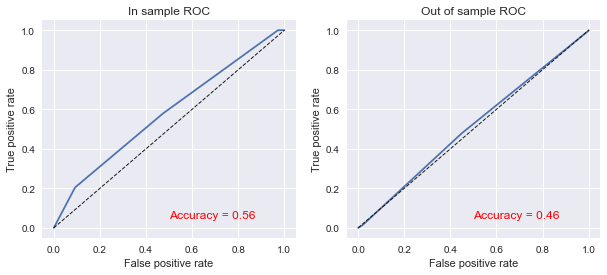

In [66]:
# In sample Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

print('')
print("Accuracy - IS")
print(accuracy_score(y_train, y_pred))



# OOS Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_predv = rf.predict(X_validate)
fpr_rfv, tpr_rfv, _ = roc_curve(y_validate, y_pred_rf)
print('')
print("Accuracy - OOS")
print(accuracy_score(y_validate, y_predv))


#Plot
fig , (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(fpr_rf, tpr_rf)
ax1.set_title('In sample ROC')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.text(0.5, 0.05, 'Accuracy = 0.56', fontsize=12,  color='red')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

ax2.plot(fpr_rfv, tpr_rfv)
ax2.set_title('Out of sample ROC')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.text(0.5, 0.05, 'Accuracy = 0.46', fontsize=12,  color='red')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)

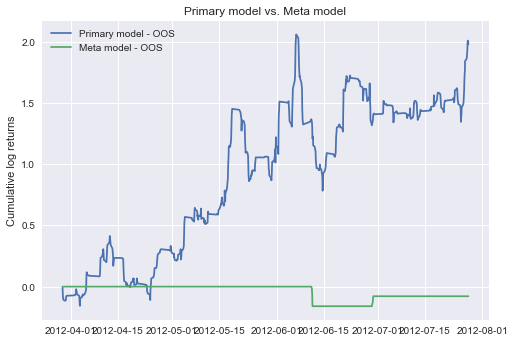

In [67]:
test_dates = X_validate.index
primary_lr = np.log(1 + labels.loc[test_dates, 'ret'])
primary_cusum = primary_lr.cumsum()
meta_lr = primary_lr * y_predv
meta_cusum = meta_lr.cumsum()

plt.plot(primary_cusum, "b", label = "Primary model - OOS")
plt.plot(meta_cusum, "g", label = "Meta model - OOS")
plt.title("Primary model vs. Meta model")
plt.legend()
plt.ylabel("Cumulative log returns")
plt.show()

In [68]:
# lets also look at some statistics instead of just a PnL curve
import pyfolio as pf
perf_func = pf.timeseries.perf_stats

def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets



primary_r = get_daily_returns(labels.loc[test_dates, 'ret'])

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_r, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

meta_r = get_daily_returns(labels.loc[test_dates, 'ret']*y_predv)

perf_stats_all = perf_func(returns=meta_r, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

print(perf_stats_df)

                     Primary Model  Meta Model
Annual return           453.494238   -0.205413
Cumulative returns        7.071129   -0.075469
Annual volatility         2.523183    0.293032
Sharpe ratio              3.596081   -0.629439
Calmar ratio            668.697992   -1.390526
Stability                 0.818838    0.459859
Max drawdown             -0.678175   -0.147723
Omega ratio               1.941524    0.573894
Sortino ratio             7.321511   -0.729405
Skew                      0.903527   -4.798833
Kurtosis                  1.564290   50.340566
Tail ratio                2.071785         NaN
Daily value at risk      -0.281885   -0.037650


C:\Users\axarz\Anaconda3\envs\blabla\lib\site-packages\empyrical\stats.py:1527: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs(np.percentile(returns, 95)) / \


### Take aways

- the primary model was just profitable cuz market was in uptrend
- secondary model had 0 predictive power and was just random guessing
- hence why primary+secondary model performance is flat